## Importing Libraries

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import pandas as pd

## Reading Data and Loading into DataLoader

In [24]:
df = pd.read_csv('data.csv')
# df1 = df[df["Personal Loan"]==1]
# df0 = df[df["Personal Loan"]==0][:480]
# df = pd.concat((df0,df1))
# df = df.sample(frac=1)
df.drop("ID",axis=1,inplace=True)

features = df.drop("Personal Loan",axis=1).columns
target = "Personal Loan"

from sklearn.model_selection import train_test_split

trainx,testx,trainy,testy = train_test_split(df[features],df[target],test_size=0.2)

traindb = pd.concat((trainx,trainy),axis=1)
testdb = pd.concat((testx,testy),axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class db(Dataset):
    def __init__(self,target,features,df) -> None:
        self.y  = torch.tensor(df[target].values)
        self.x = torch.tensor(df[features].values)
        self.x = scaler.fit_transform(self.x)

    def __len__(self) -> int:
        return len(self.y)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

traindbt = db(target,features,traindb)
testdbt = db(target,features,testdb)

train_loader = DataLoader(traindbt,batch_size=len(traindb),shuffle=True)
test_loader = DataLoader(testdbt,batch_size=len(testdb),shuffle=False)

## Creating Particle Class

In [25]:
xlim = 10

def fitness(position,model,loss,x,y):
    a = model.l1.in_features * model.l1.out_features
    b = a + model.l1.out_features
    c = b + (model.l3.in_features * model.l3.out_features)
    # d = c + model.l3.out_features

    weights1 = torch.tensor(position[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
    bias1 = torch.tensor(position[a:b]).to(torch.float32)
    weights2 = torch.tensor(position[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
    bias2 = torch.tensor(position[c:]).to(torch.float32)

    model.l1.weight = nn.Parameter(weights1)
    model.l1.bias = nn.Parameter(bias1)
    model.l3.weight = nn.Parameter(weights2)
    model.l3.bias = nn.Parameter(bias2)

    y_ = model(x)
    j = loss(y_,y.unsqueeze(-1))
    
    return j

class particle:
    def __init__(self,w,c1,c2,l,model,loss,x,y):
        self.l = l
        self.model = model
        self.loss = loss
        self.x, self.y = x,y
        self.position = np.random.random(l)*20-xlim
        self.velocity = np.random.random(l)
        self.fitness = fitness(self.position,self.model,self.loss,self.x,self.y)
        self.pbest = [self.fitness] + [i for i in self.position]
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.r1, self.r2 = np.random.random(2)

    def calc_velocity(self,gbest):
        soc = self.calc_soc(gbest)
        cog = self.calc_cog()

        self.velocity = self.w * self.velocity + soc + cog
    
    def calc_soc(self,gbest):
        return self.c1 * self.r1 * (np.array([i for i in gbest][1:]) - self.position)
    
    def calc_cog(self):
        return self.c2 * self.r2 * (np.array([i for i in self.pbest][1:]) - self.position)
    
    def iterate(self,gbest):

        self.calc_velocity(gbest)

        self.position += self.velocity

        self.position = np.clip(self.position,-xlim,xlim)

        self.fitness = fitness(self.position,self.model,self.loss,self.x,self.y)

        if self.fitness<self.pbest[0]:
            self.pbest[0] = self.fitness
            for i in range(len(self.position)):
                self.pbest[i+1] = self.position[i]
        
        self.r1, self.r2 = np.random.rand(2)*2

def calc_gbest(l):
    global gbest
    for i in l:
        if i.pbest[0]<gbest[0]:
            gbest[0] = i.pbest[0]
            for j in range(len(i.position)):
                gbest[j+1] = i.position[j]

## Defining Neural Network (PyTorch)
### Neural Network Architecture:
- Input Layer: 12
- Hidden Layer: 16
- Output Layer: 1

In [26]:
class net(nn.Module):
    def __init__(self) -> None:
        super(net,self).__init__()

        self.l1 = nn.Linear(12,16)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(16,1)
        self.l4 = nn.Sigmoid()
        # self.l5 = nn.Linear(20,1)
        # self.l6 = nn.Sigmoid()
    
    def forward(self,X):
        
        x = X

        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        # x = self.l5(x)
        # x = self.l6(x)

        return x

## Training

In [27]:
model = net()
learning_rate = 0.01

loss = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(),lr=learning_rate)

epochs = 1000

model = model.to(torch.float32)

weights = []
params = list(model.parameters()).copy()
for i in range(len(params)):
    weights += params[i].flatten().detach().tolist()
weights = np.array(weights)

sample = iter(train_loader)
x,y = next(sample)
x = x.to(torch.float32)
y = y.to(torch.float32)

losses = []


# model.l3(model.l2(model.l1(x)))

c1,c2 = 0.3,0.3 #cog,soc
l = [particle(0.8,c1,c2,weights.shape[0],model,loss,x,y) for i in range(500)]
gbest = np.ones(weights.shape[0]+1)*10000
calc_gbest(l)

def iterate():
    calc_gbest(l)
    
    for i in l:
        i.iterate(gbest)
        
for epoch in range(epochs):
    for i,(x,y) in enumerate(train_loader):
        x = x.to(torch.float32)
        y = y.to(torch.float32)

        optim.zero_grad()
        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))
        j.backward()
        # optim.step()

        iterate()

        losses += [gbest[0].item()]

        print(f"Epoch: {epoch}/{epochs} Step: {i} Loss: {gbest[0].item()}")

Epoch: 0/1000 Step: 0 Loss: 9.311022758483887
Epoch: 1/1000 Step: 0 Loss: 8.740114212036133
Epoch: 2/1000 Step: 0 Loss: 6.079076766967773
Epoch: 3/1000 Step: 0 Loss: 5.8807692527771
Epoch: 4/1000 Step: 0 Loss: 5.250324249267578
Epoch: 5/1000 Step: 0 Loss: 4.473321914672852
Epoch: 6/1000 Step: 0 Loss: 3.2681779861450195
Epoch: 7/1000 Step: 0 Loss: 2.279283285140991
Epoch: 8/1000 Step: 0 Loss: 2.0014750957489014
Epoch: 9/1000 Step: 0 Loss: 2.0014750957489014
Epoch: 10/1000 Step: 0 Loss: 1.749413013458252
Epoch: 11/1000 Step: 0 Loss: 1.749413013458252
Epoch: 12/1000 Step: 0 Loss: 1.597507357597351
Epoch: 13/1000 Step: 0 Loss: 1.5912160873413086
Epoch: 14/1000 Step: 0 Loss: 1.4427019357681274
Epoch: 15/1000 Step: 0 Loss: 1.3049299716949463
Epoch: 16/1000 Step: 0 Loss: 1.1568392515182495
Epoch: 17/1000 Step: 0 Loss: 1.0250221490859985
Epoch: 18/1000 Step: 0 Loss: 0.8341812491416931
Epoch: 19/1000 Step: 0 Loss: 0.6874483227729797
Epoch: 20/1000 Step: 0 Loss: 0.5920668840408325
Epoch: 21/1000

## Test Accuracy

In [28]:
with torch.no_grad():
    n_correct=0
    n_samples=0

    for x,y in test_loader:

        x = x.to(torch.float32)
        y = y.to(torch.float32)

        a = model.l1.in_features * model.l1.out_features
        b = a + model.l1.out_features
        c = b + (model.l3.in_features * model.l3.out_features)
        # d = c + model.l3.out_features

        position = gbest[1:]

        weights1 = torch.tensor(position[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
        bias1 = torch.tensor(position[a:b]).to(torch.float32)
        weights2 = torch.tensor(position[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
        bias2 = torch.tensor(position[c:]).to(torch.float32)

        model.l1.weight = nn.Parameter(weights1)
        model.l1.bias = nn.Parameter(bias1)
        model.l3.weight = nn.Parameter(weights2)
        model.l3.bias = nn.Parameter(bias2)

        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))

        output = model(x)

        pred = torch.round(output).reshape(1,-1)
        n_samples += y.shape[0]
        n_correct += (pred==y).sum().item()
        # print(n_correct)
    acc = 100*(n_correct/n_samples)
    print(f"Accuracy: {acc}")

Accuracy: 93.7


## Loss Curve

Text(0, 0.5, 'Loss')

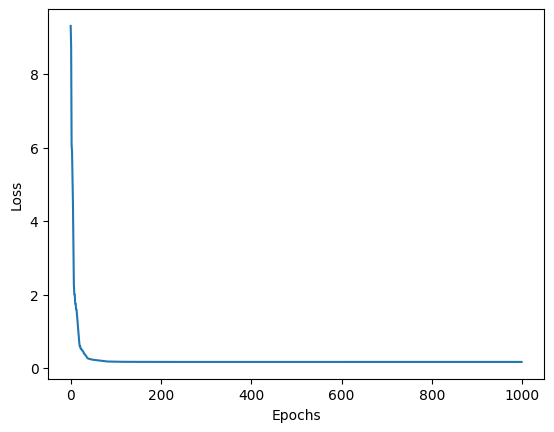

In [29]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")